# Introduction

This IBM sample dataset contains information about Telco customers. Each row represents unique costumer, 
while columns identifies information about customer’s services, account, demographic data and __churn status__ (indication whether the customer left within a month or not).

__Raw data contains:__
<br> 7043 rows (customers);
<br> 21 columns (features).
    
Analysis focuses on the behavior of telecom customers who are more likely to leave the platform. <br> __The aim:__ is to represent given data by churn breakdown and build Logistic Regression model with only significant features.


In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pylab as pl
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
%matplotlib inline

import matplotlib as mpl
from scipy import stats

# Data overview

__Observations:__
<br> 11 missing values in the TotalCharges column, which account for only 0.16% of the total number of observations. 
<br> 3 continuous variables (Tenure, MonthlyCharges and TotalCharges).

In [131]:
telco=pd.read_csv('Churn.csv')
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One_year,No,Bank_transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber_optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [132]:
print('Type:\n\n',telco.dtypes)

Type:

 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [133]:
telco.TotalCharges = pd.to_numeric(telco.TotalCharges, errors=0)
print('Missing values in dataset:\n\n', telco.isnull().sum())

Missing values in dataset:

 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [134]:
telco.dropna(inplace = True)
telco['SeniorCitizen'] = telco['SeniorCitizen'].replace({1:"Yes",0:"No"})
telco.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [135]:
telco.drop(['customerID', 'MultipleLines', 'StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
for i in replace_cols : 
    telco[i]  = telco[i].replace({'No internet service' : 'No'})

# Focus variable

As it was mentioned before, our focus variable is __churn__ that identifies customers who left within the last month. 
<br> It counts for more than a quarter of all data (around 27%).

Churn: Yes -  5163 ( 73.42 %)
Churn: No -  1869 ( 26.58 %)


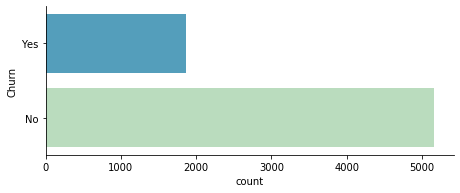

In [136]:
ax = sns.catplot(y='Churn', kind='count', data=telco, height=2.6, aspect=2.5, orient='h',palette='GnBu_r',
                 order=['Yes','No'])
print('Churn: Yes - ', Yes,  '(', round(Yes/len(y)*100,2), '%)')
print('Churn: No - ', No,  '(', round(No/len(y)*100,2), '%)')
telco['Churn']=telco['Churn'].replace({'Yes':1,'No':0})

# Categoriacal data visualization with respect to churn

<br> The churn percent is almost equal in case of Male and Female, while senior citizens has significantly higher churn rate in relation with those who have not this status.
<br> Customers with Partners and Dependents have lower churn rate in comparison to those who have not.
<br> Churn percent is higher in case of cutsomers having paperless billing option.
<br> Not surprisingly, that lowest churn percentage is in customers group with the longest contract (Two-year).
<br> Electronic check is type of payment that has significantly higher churn rate.


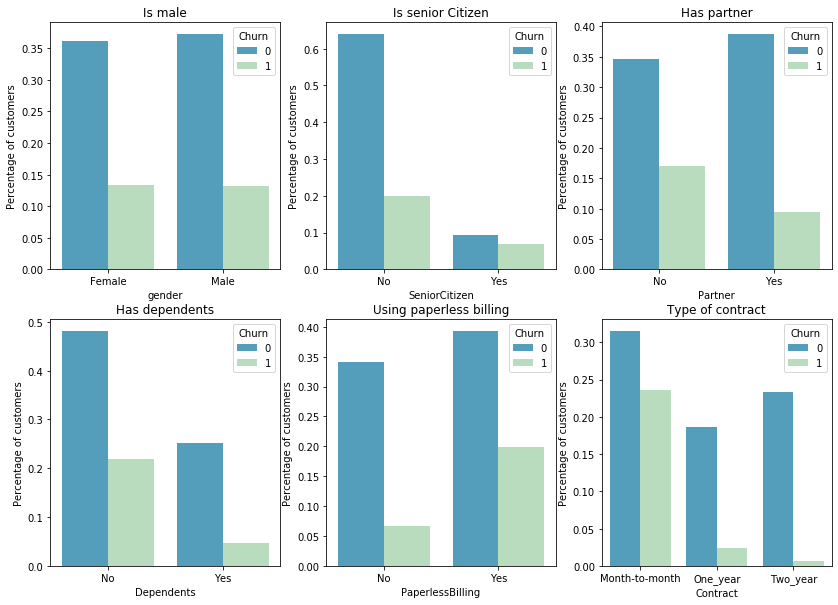

In [137]:
fig, axis = plt.subplots(2, 3, figsize=(14,10))
axis[0,0].set_title('Is male')
axis[0,1].set_title('Is senior Citizen')
axis[0,2].set_title('Has partner')
axis[1,0].set_title('Has dependents')
axis[1,1].set_title('Using paperless billing')
axis[1,2].set_title('Type of contract')

axis_y = 'Percentage of customers'


gender_pl = telco.groupby('gender')['Churn'].value_counts()/len(telco)
gender_pl = gender_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='gender', y= axis_y, hue='Churn', data=gender_pl, ax=axis[0,0], palette='GnBu_r')

SeniorCitizen_pl = telco.groupby('SeniorCitizen')['Churn'].value_counts()/len(telco)
SeniorCitizen_pl = SeniorCitizen_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='SeniorCitizen', y= axis_y, hue='Churn', data=SeniorCitizen_pl, ax=axis[0,1], palette='GnBu_r')

partner_pl = telco.groupby('Partner')['Churn'].value_counts()/len(telco)
partner_pl = partner_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=partner_pl, ax=axis[0,2], palette='GnBu_r')

depend_pl = telco.groupby('Dependents')['Churn'].value_counts()/len(telco)
depend_pl = depend_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=depend_pl, ax=axis[1,0], palette='GnBu_r')

paperlessbil_pl = telco.groupby('PaperlessBilling')['Churn'].value_counts()/len(telco)
paperlessbil_pl = paperlessbil_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='PaperlessBilling', y= axis_y, hue='Churn', data=paperlessbil_pl, ax=axis[1,1], palette='GnBu_r')

contract_pl = telco.groupby('Contract')['Churn'].value_counts()/len(telco)
contract_pl = contract_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Contract', y= axis_y, hue='Churn', data=contract_pl, ax=axis[1,2], palette='GnBu_r')


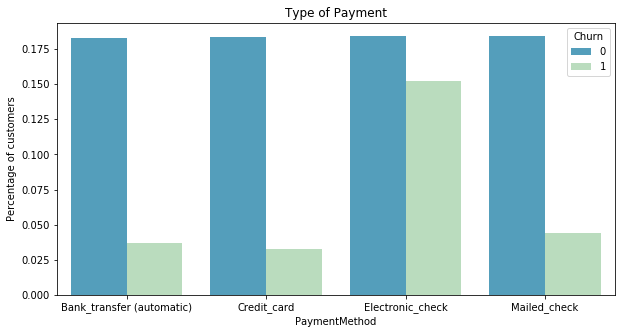

In [138]:
fig, axis = plt.subplots(1, 1, figsize=(10,5))
axis.set_title('Type of Payment')

axis_y = 'Percentage of customers'


PaymentM_pl = telco.groupby('PaymentMethod')['Churn'].value_counts()/len(telco)
PaymentM_pl = PaymentM_pl.to_frame().rename({'Churn': axis_y}, axis=1).reset_index()
ax = sns.barplot(x='PaymentMethod', y= axis_y, hue='Churn', data=PaymentM_pl, ax=axis, palette='GnBu_r')



# Outliers detection

In order to ascertain whatever sample comtains outliers or not, few tests are used.
<br> Due to results shown below, no data will be removed for further investigation.

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

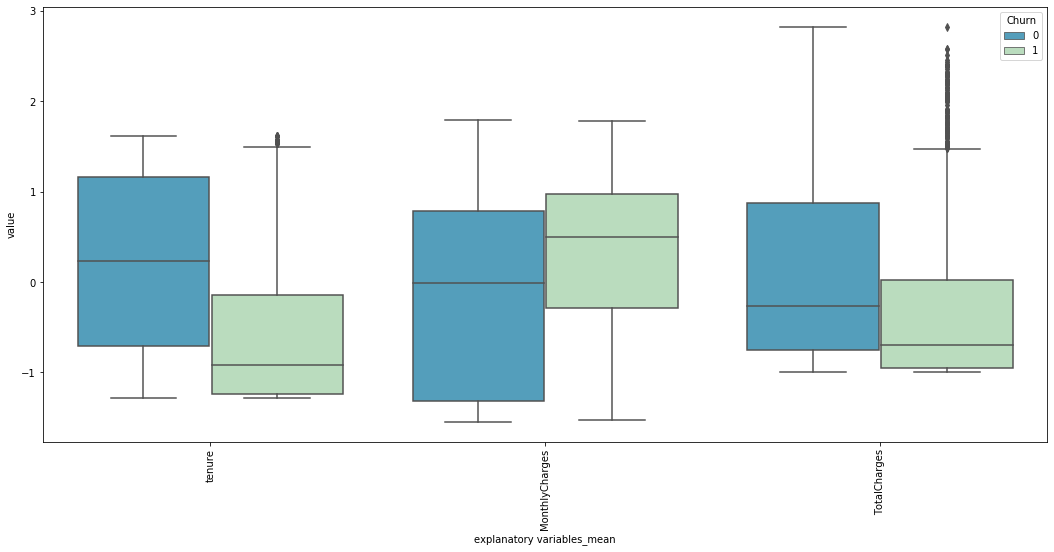

In [139]:
num=telco[['tenure', 'MonthlyCharges', 'TotalCharges']]

telco_num_stand=(num-num.mean())/(num.std())

telco_numeric = pd.concat([y,telco_num_stand], axis=1) 
telco_numeric = pd.melt(telco_numeric,id_vars='Churn',
                    var_name='explanatory variables_mean',
                    value_name='value')

plt.figure(figsize=(18,8))
sns.boxplot(x='explanatory variables_mean', y='value', hue='Churn', palette='GnBu_r', data=telco_numeric)
plt.xticks(rotation=90)

In [140]:
def outliers(x): 
       return np.abs(x - x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))

In [141]:
telco[outliers(telco.TotalCharges)].head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
15,Female,No,Yes,Yes,69,Yes,Fiber_optic,Yes,Yes,Yes,Yes,Two_year,No,Credit_card,113.25,7895.15,0
17,Male,No,No,Yes,71,Yes,Fiber_optic,Yes,No,Yes,No,Two_year,No,Bank_transfer (automatic),106.70,7382.25,0
30,Female,Yes,Yes,No,71,Yes,Fiber_optic,Yes,Yes,Yes,Yes,Two_year,Yes,Credit_card,96.35,6766.95,0
35,Female,No,Yes,Yes,72,Yes,Fiber_optic,Yes,Yes,No,Yes,Two_year,No,Bank_transfer (automatic),99.90,7251.70,0
57,Male,Yes,Yes,Yes,66,Yes,Fiber_optic,No,Yes,Yes,Yes,One_year,Yes,Electronic_check,108.45,7076.35,0


In [142]:
def find_outliers(data):
    absolute_normalized = np.abs(stats.zscore(data))
    return absolute_normalized > 3

In [143]:
a=find_outliers(telco.TotalCharges)
sum(a)

0

In [144]:
outliers = np.abs(stats.zscore(telco.TotalCharges))
sum(outliers>3)

0

# Multicollinearity check

For multicollinearity check correlation matrix is used. 
<br> As it is visualized below, there are only two points that have to attract our attention:
    <br> &emsp; TotalCharges with tenure (corr of 0.83). For this moment we will leave both these variables and will check at logistic regresion stage;
    <br> &emsp; MonthlyCharges with InternetService_fiber_optic and InternetService_No (0.79 and 0.76 respectively). Both these variables will be removed due to insignificance in Logistic Regression stage.

In [145]:
telco_dummies = pd.get_dummies(telco, drop_first=True)
telco=telco_dummies

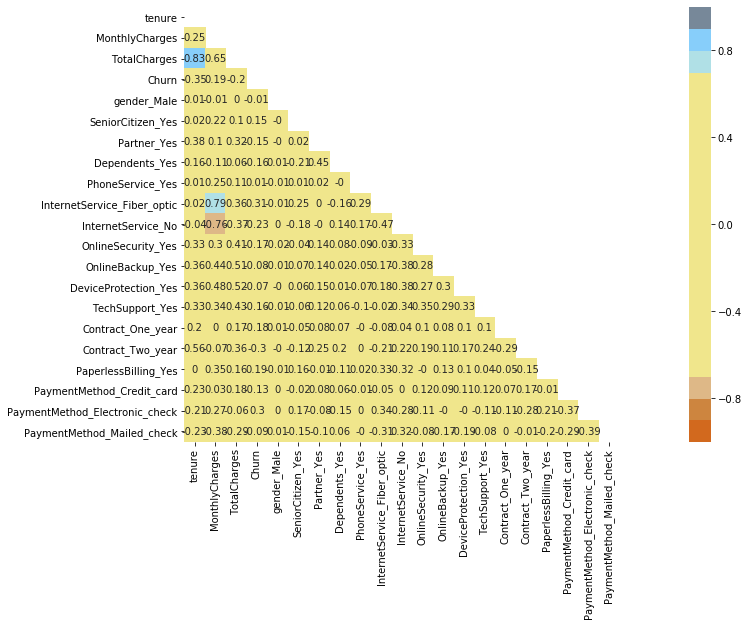

In [146]:
# Mask for the upper triangle
corr=telco.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
plt.figure(figsize=(25,8))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, 
            cmap=['Chocolate','Peru','Burlywood','Khaki','Khaki',
                  'Khaki','Khaki','Khaki','Khaki','Khaki',
                  'Khaki','Khaki','Khaki','Khaki','Khaki',
                  'Khaki', 'Khaki','Powderblue', 'Lightskyblue','Lightslategrey'],
            square=True)

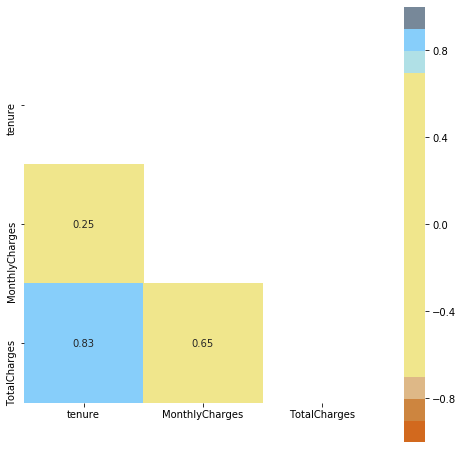

In [147]:
# Mask for the upper triangle
corr=num.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, 
            cmap=['Chocolate','Peru','Burlywood','Khaki','Khaki',
                  'Khaki','Khaki','Khaki','Khaki','Khaki',
                  'Khaki','Khaki','Khaki','Khaki','Khaki',
                  'Khaki', 'Khaki','Powderblue', 'Lightskyblue','Lightslategrey'],
            square=True)

# Test-train split

In [148]:
X=telco.drop(['Churn'], axis=1)
y=telco.Churn
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, random_state=1) 

In [149]:
for var in [X_train, X_test, y_train, y_test]:
    print (var.shape)


(5625, 20)
(1407, 20)
(5625,)
(1407,)


# Predictions

Firstly the __Base LR Model__ is built, that brings:
<br>__Precision:__ &emsp;&emsp;&emsp;&emsp;&emsp; 0.627831715210356
<br>__Recall:__ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 0.5300546448087432
<br>__Accuracy:__ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 0.7960199004975125
<br>__Area under the curve:__ &emsp; 0.709791971779972

Since 7 variables are insignificant (p-value> 0.05), they have to be removed step by step from the model. 
<br> TotalCharges are also removed from the final model as it brings better model performance (high corr with tenure).

The final __LR model__:
<br>__Precision:__ &emsp;&emsp;&emsp;&emsp;&emsp;  0.625
<br>__Recall:__ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 0.5327868852459017
<br>__Accuracy:__ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 0.7953091684434968
<br>__Area under the curve:__ &emsp; 0.7101974772050834  

In [150]:
lg=LogisticRegression()

lg.fit(X_train, y_train)
predictions=lg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [151]:
conf=metrics.confusion_matrix(y_test, predictions)
conf

array([[926, 115],
       [172, 194]], dtype=int64)

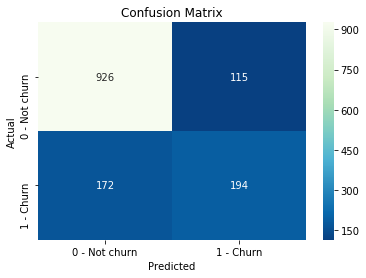

In [152]:
fig, ax = plt.subplots()
ax= plt.subplot()
sns.heatmap(conf,annot=True, ax = ax, cmap='GnBu_r', fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0 - Not churn', '1 - Churn'])
ax.yaxis.set_ticklabels(['0 - Not churn', '1 - Churn']);

In [153]:
print('Precision:\t\t', metrics.precision_score(y_test, predictions))
print('Recall:\t\t\t', metrics.recall_score(y_test, predictions))
print('Accuracy:\t\t', metrics.accuracy_score(y_test, predictions))
print('Area under the curve:\t', metrics.roc_auc_score(y_test, predictions))

Precision:		 0.627831715210356
Recall:			 0.5300546448087432
Accuracy:		 0.7960199004975125
Area under the curve:	 0.709791971779972


In [154]:
est=smf.logit('y ~ tenure + MonthlyCharges + gender_Male + Partner_Yes + Dependents_Yes + InternetService_No + InternetService_Fiber_optic + InternetService_No +  TotalCharges + SeniorCitizen_Yes + PhoneService_Yes + OnlineSecurity_Yes + OnlineBackup_Yes + DeviceProtection_Yes + TechSupport_Yes + Contract_One_year + Contract_Two_year + PaperlessBilling_Yes + PaymentMethod_Electronic_check + PaymentMethod_Credit_card + PaymentMethod_Mailed_check',X).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 0.414769
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7011
Method:                           MLE   Df Model:                           20
Date:                Mon, 16 Sep 2019   Pseudo R-squ.:                  0.2837
Time:                        00:44:10   Log-Likelihood:                -2916.7
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.3869      0.227     -1.702      0.089      -0.832       0.059
tenure                            -0.0599      0.006     -9.641      0.000      -0.072      -0.048
MonthlyCharges                     0.0208      0.005      4.380      0.000       0.012       0.030
gender_Male                       -0.0240      0.065     -0.371      0.711      -0.151       0.103
Partner_Yes                        0.0043      0.078      0.055      0.956      -0.148       0.157
Dependents_Yes                    -0.1508      0.090     -1.682      0.093      -0.326       0.025
InternetService_No                -0.2626      0.192     -1.370      0.171      -0.638       0.113
InternetService_Fiber_optic        0.2373      0.156      1.518      0.129      -0.069       0.544
TotalCharges                       0.0003   7.04e-05      4.724      0.000       0.000       0.000
SeniorCitizen_Yes                  0.2212      0.084      2.623      0.009       0.056       0.387
PhoneService_Yes                  -1.0101      0.156     -6.477      0.000      -1.316      -0.704
OnlineSecurity_Yes                -0.5112      0.086     -5.910      0.000      -0.681      -0.342
OnlineBackup_Yes                  -0.2772      0.080     -3.474      0.001      -0.434      -0.121
DeviceProtection_Yes              -0.1616      0.085     -1.899      0.058      -0.328       0.005
TechSupport_Yes                   -0.4949      0.090     -5.511      0.000      -0.671      -0.319
Contract_One_year                 -0.6776      0.107     -6.320      0.000      -0.888      -0.467
Contract_Two_year                 -1.3683      0.176     -7.755      0.000      -1.714      -1.022
PaperlessBilling_Yes               0.3495      0.074      4.695      0.000       0.204       0.495
PaymentMethod_Electronic_check     0.3033      0.094      3.213      0.001       0.118       0.488
PaymentMethod_Credit_card         -0.0873      0.114     -0.766      0.444      -0.311       0.136
PaymentMethod_Mailed_check        -0.0612      0.115     -0.533      0.594      -0.286       0.164
==================================================================================================
"""

In [155]:
X.drop(['gender_Male', 'Partner_Yes', 'Dependents_Yes','InternetService_No','InternetService_Fiber_optic', 
       'PaymentMethod_Credit_card', 'TotalCharges', 'PaymentMethod_Mailed_check'], axis=1, inplace=True)

In [156]:
est=smf.logit('y ~ tenure + MonthlyCharges + SeniorCitizen_Yes + PhoneService_Yes + OnlineSecurity_Yes + OnlineBackup_Yes + DeviceProtection_Yes + TechSupport_Yes + Contract_One_year + Contract_Two_year + PaperlessBilling_Yes + PaymentMethod_Electronic_check',X).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 0.416902
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7019
Method:                           MLE   Df Model:                           12
Date:                Mon, 16 Sep 2019   Pseudo R-squ.:                  0.2800
Time:                        00:44:28   Log-Likelihood:                -2931.7
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.1695      0.120     -9.735      0.000      -1.405      -0.934
tenure                            -0.0340      0.002    -15.528      0.000      -0.038      -0.030
MonthlyCharges                     0.0338      0.002     18.383      0.000       0.030       0.037
SeniorCitizen_Yes                  0.2561      0.083      3.084      0.002       0.093       0.419
PhoneService_Yes                  -1.0707      0.125     -8.598      0.000      -1.315      -0.827
OnlineSecurity_Yes                -0.5391      0.083     -6.465      0.000      -0.703      -0.376
OnlineBackup_Yes                  -0.2820      0.077     -3.647      0.000      -0.434      -0.130
DeviceProtection_Yes              -0.1837      0.080     -2.287      0.022      -0.341      -0.026
TechSupport_Yes                   -0.5263      0.085     -6.205      0.000      -0.693      -0.360
Contract_One_year                 -0.7063      0.105     -6.719      0.000      -0.912      -0.500
Contract_Two_year                 -1.3758      0.173     -7.954      0.000      -1.715      -1.037
PaperlessBilling_Yes               0.3442      0.074      4.653      0.000       0.199       0.489
PaymentMethod_Electronic_check     0.3451      0.069      4.983      0.000       0.209       0.481
==================================================================================================
"""

In [157]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, random_state=1) 

In [158]:
for var in [X_train, X_test, y_train, y_test]:
    print (var.shape)


(5625, 12)
(1407, 12)
(5625,)
(1407,)


In [159]:
lg=LogisticRegression()

lg.fit(X_train, y_train)
predictions=lg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [160]:
conf2= metrics.confusion_matrix(y_test, predictions)
conf2

array([[924, 117],
       [171, 195]], dtype=int64)

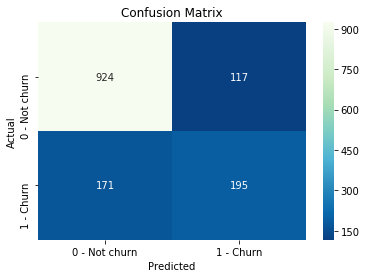

In [161]:
ax= plt.subplot()
sns.heatmap(conf2,annot=True, ax = ax, cmap='GnBu_r', fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0 - Not churn', '1 - Churn'])
ax.yaxis.set_ticklabels(['0 - Not churn', '1 - Churn']);

In [162]:
print('Precision:\t\t', metrics.precision_score(y_test, predictions))
print('Recall:\t\t\t', metrics.recall_score(y_test, predictions))
print('Accuracy:\t\t', metrics.accuracy_score(y_test, predictions))
print('Area under the curve:\t', metrics.roc_auc_score(y_test, predictions))

Precision:		 0.625
Recall:			 0.5327868852459017
Accuracy:		 0.7953091684434968
Area under the curve:	 0.7101974772050834


# Conclusions

The final model has slightly lower precision and accuracy, but higher recall and AUC.